<a href="https://colab.research.google.com/github/gulnuravci/financial_sentiment_analysis/blob/main/reddit_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I want to build a tool that gives a daily rundown of reddit user's sentiment on the "Magnificent Seven" - Apple, Microsoft, Alphabet, Amazon, Nvidia, Tesla, and Meta.

I am doing this as a proof of concept.

# Set up

## Installs

In [ ]:
pip install asyncpraw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
pip install transformers datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (

In [ ]:
pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2


In [ ]:
pip install huggingface_hub

## Imports

In [ ]:
import asyncpraw
import asyncio
import torch
import pandas as pd
import pprint
import tqdm
import re
import csv
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import requests
import asyncprawcore

from pathlib import Path
from google.colab import drive
from typing import List, Dict, Any
from google.colab import userdata
from collections import defaultdict
from asyncpraw.models import MoreComments, Submission
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from huggingface_hub import InferenceClient, notebook_login
from datetime import datetime

## Access reddit

In [ ]:
def get_access_to_reddit(user_agent="financial sentiment analysis project (research phase) (by u/ditalinianalysis)"):
  reddit = asyncpraw.Reddit(
      client_id=userdata.get("client_id"),
      client_secret=userdata.get('secret'),
      user_agent=user_agent
      )
  return reddit

## Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extracting data

What are some ways to get data on what we are looking for?
- Look at a list of subs
- Search for posts that include a list of keywords

What is a reliable way to relate comments to each other and the post? Is it sufficient to make them a single string?

## Exploring reddit.subreddits

In [ ]:
async def search_subreddits_by_name(search_string: str,
                                    include_nsfw: bool,
                                    exact: bool) -> List[asyncpraw.models.Subreddit]:
  """
  async for ... in search_by_name(query: str, *, include_nsfw: bool = True, exact: bool = False) → List[asyncpraw.models.Subreddit]

  Return list of Subreddits whose names begin with query.

  Parameters:
  query – Search for subreddits beginning with this string.
  exact – Return only exact matches to query (default: False).
  include_nsfw – Include subreddits labeled NSFW (default: True).
  """
  subs = []
  async for subreddit in reddit.subreddits.search_by_name(search_string, include_nsfw=include_nsfw, exact=exact):
    subs.append(subreddit)
  return subs

In [ ]:
async def search_subreddits_by_keyword_in_name_or_title(search_string: str) -> List[asyncpraw.models.Subreddit]:
  """
  search(query: str, **generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[asyncpraw.models.Subreddit]

  Return a ListingGenerator of subreddits matching query. Additional keyword arguments are passed in the initialization of ListingGenerator.

  Subreddits are searched by both their title and description.

  Parameters:
  query – The query string to filter subreddits by.
  """
  subs = []
  async for subreddit in reddit.subreddits.search(search_string):
    subs.append(subreddit)
  return subs

In [ ]:
async def filter_subreddits_by_keywords(subreddits: List[asyncpraw.models.Subreddit], keywords: List[str], min_keyword_count: int = 2) -> List[asyncpraw.models.Subreddit]:
  filtered_subreddits = []

  for subreddit in subreddits:
      title = subreddit.title.lower()
      description = subreddit.description.lower() if subreddit.description else ""


      # Check if the subreddit contains a minimum number of keywords
      keyword_count = sum(keyword.lower() in title or keyword.lower() in description for keyword in keywords)
      if keyword_count >= min_keyword_count:
          filtered_subreddits.append(subreddit)

  return filtered_subreddits

In [ ]:
def get_subreddits_name_title_description(subreddits: List[asyncpraw.models.Subreddit]) -> Dict[asyncpraw.models.Subreddit,str]:
  subreddit_name_title_descriptions = {}
  for subreddit in subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = subreddit.description if subreddit.description else ""
    text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
    subreddit_name_title_descriptions[subreddit] = text[:512]
  return subreddit_name_title_descriptions

## Exploring reddit.front

"Sorting by "new" will frequently update to show you new posts. Sorting by "Hot" and "Best" are similar, but sorting by "Hot" should surface fresher posts as it is related to upvotes + time. Sorting by "Top" will surface posts with the highest vote counts within the selected time frame."

In [ ]:
async def front_best_posts() -> List[asyncpraw.models.Submission]:
  """
  best(**generator_kwargs: str | int)→ AsyncIterator[asyncpraw.models.Submission]

  Return a ListingGenerator for best items. Additional keyword arguments are passed in the initialization of ListingGenerator.
  """
  posts = []
  async for post in reddit.front.best():
    posts.append(post)
  return posts

In [ ]:
async def front_hot_posts(time_filter: str = "day") -> List[asyncpraw.models.Submission]:
  """
  hot(**generator_kwargs: str | int | Dict[str, str])→ AsyncIterator[Any]

  Return a ListingGenerator for hot items.

  Additional keyword arguments are passed in the initialization of ListingGenerator.
  """
  posts = []
  async for post in reddit.front.hot():
    posts.append(post)
  return posts


## Useful functions

In [ ]:
def get_submission_information(submission: asyncpraw.models.Submission) -> Dict[str, Any]:
  """
  Submission class: https://asyncpraw.readthedocs.io/en/stable/code_overview/models/submission.html#asyncpraw.models.Submission
  """
  return vars(submission)

In [ ]:
 async def probe_subs_for_posts(subs: List[str],
                                num_posts: int,
                                time_filter: str = "day"):
  """
  Iterate through selected subreddits, retrieve a specified number of top posts from each subreddit,
  sort the comments for each post and pick the top few comments along with some of its replies,
  and store the posts.

  Args:
      subs (List[str]): A list of subreddit names to probe for posts.
      num_posts (int): The number of top posts to retrieve from each subreddit.
      time_filter (str, optional): The time period to filter posts by. Default is "day".
          Possible values: "all", "day", "hour", "month", "week", "year".

  Returns:
      defaultdict: A defaultdict where keys are subreddit names and values are lists of
      top posts retrieved from each subreddit.
  """
  # key -> subreddit, value -> list of posts
  posts = defaultdict(list)
  failed_subreddits = []
  # for each subreddit
  for sub in subs:
    try:
      async for submission in sub.top(limit=num_posts, time_filter=time_filter):
        posts[sub].append(submission)
    except Exception as e:
      print(f"Error processing posts from subreddit {sub.display_name}")
      failed_subreddits.append(sub.display_name)
  return posts, failed_subreddits

In [ ]:
async def probe_submissions_for_comments(submission: asyncpraw.models.Submission,
                                         num_comments: int,
                                         sort_type: str) -> List[asyncpraw.models.Comment]:
  """
  Retrieve comments from a Reddit submission and return a list of comments.

  Args:
      submission (asyncpraw.models.Submission): The Reddit submission object.
      num_comments (int): The number of comments to retrieve.
      sort_type (str): The sorting type for comments.
          Possible values: 'confidence', 'top', 'new', 'controversial', 'old', 'random', 'qa'.

  Returns:
      List[asyncpraw.models.Comment]: A list of comment objects retrieved from the submission.

  Note:
      - This function sorts the comments based on the specified sort_type.
      - If there are 'MoreComments' objects encountered, they are skipped.
  """
  comments_list = []
  submission.comment_sort = sort_type
  submission.comment_limit = num_comments
  await submission.load()

  comments = await submission.comments()
  comments.replace_more(limit=None)
  all_comments = comments.list()
  for comment in all_comments:
    if isinstance(comment, MoreComments):
      continue
    comments_list.append(comment)
  return comments_list

In [ ]:
from collections import defaultdict

def default_dict_list():
  return defaultdict(list)

def default_dict_dict_list():
  return defaultdict(default_dict_list)

def default_dict_dict_dict_list():
  return defaultdict(default_dict_dict_list)

In [ ]:
def create_experiment_file(filename):
  timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  with open(filename, 'a') as file:
      file.write("Experiment Tracking File\n")
      file.write(f"{timestamp}\n")
      file.write("----------------------------\n")

def add_to_experiment_file(filename, data):
    with open(filename, 'a') as file:
        file.write(f"{data}\n")

# Models

## Topic Classifier (Subreddit Descriptions)

1. Need a topic classifier fine-tuned on subreddit descriptions to distinguish if that subreddit has to do with specific technology companies/stocks.

2. Need a topic classifier that will classify if a submission is technology related.

### Clean Text

In [ ]:
def clean_text(raw_text):
    # Remove newline characters
    cleaned_text = raw_text.replace('\n', ' ')

    # Remove URLs
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)

    # Remove special characters and multiple spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

### Data Collection

Get subreddit title and descriptions based on keywords. Will manually label whether it is technology related or not in a google sheets.

In [ ]:
reddit = get_access_to_reddit()

In [ ]:
technology_keywords = ["Tesla", "Meta"]

In [ ]:
all_subreddits = []
for keyword in technology_keywords:
  curr_keyword_subreddits = await search_subreddits_by_keyword_in_name_or_title(keyword)
  for subreddit in curr_keyword_subreddits:
    name = subreddit.display_name
    title = subreddit.title
    description = clean_text(subreddit.description) if subreddit.description else ""
    all_subreddits.append("Name:" + name + "\nTitle:" + title + "\nDescription:" + description)

In [ ]:
def create_or_append_csv(csv_file_path, data, append=False):
  path = Path(csv_file_path)

  # If append is True and and file path doesn't exist, end function
  if append and not path.exists():
    print("Asked to append and", path, "path does not exist.")
    return

  # Open the CSV file in append mode if specified
  mode = 'a' if append else 'w'

  with open(path, mode, newline='', encoding='utf-8') as file:
    writer = csv.writer(file)

    # Write the header only if the file is newly created or not in append mode
    if not append:
        writer.writerow(["Text"])

    writer.writerows(map(lambda x: [x], data))

  if append:
      print(f"Data appended to existing CSV file '{path}'.")
  else:
      print(f"New CSV file '{path}' created successfully.")

In [ ]:
create_or_append_csv(csv_file_path="tesla_meta_unlabeled_dataset", data=all_subreddits, append=False)

New CSV file 'nvidia_unlabeled_dataset' created successfully.


In [ ]:
len(all_subreddits)

200

### Import labeled data and create training and test split

Import csv data from github, which is a single csv of labeled subreddit descriptions.

In [ ]:
!git clone https://github.com/gulnuravci/financial_sentiment_analysis
!cp financial_sentiment_analysis/technology_topic_classification_dataset.csv .

Cloning into 'financial_sentiment_analysis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 334.66 KiB | 2.57 MiB/s, done.


Remove duplicates and plot what the [not] technology related subreddits.

Number of duplicates dropped: 122
Number of not technology related subreddits: 582
Number of technology related subreddits: 501


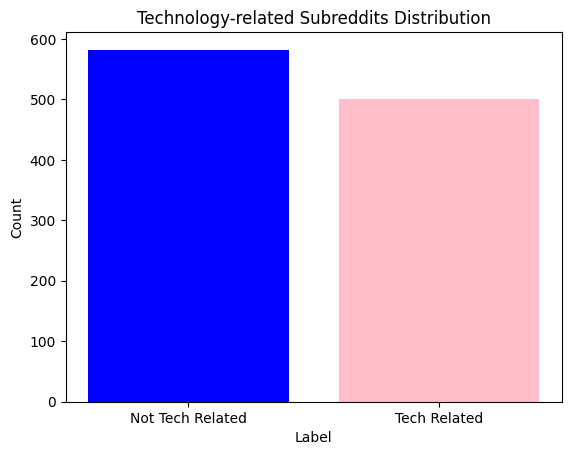

In [ ]:
def remove_duplicates_and_print(data_frame):
    # Drop duplicates based on the 'Text' column
    unique_df = data_frame.drop_duplicates(subset='Text', keep='first')

    print(f"Number of duplicates dropped: {len(data_frame) - len(unique_df)}")

    return unique_df

csv_file_path = 'financial_sentiment_analysis/technology_topic_classification_dataset.csv'

df = pd.read_csv(csv_file_path)

unique_df = remove_duplicates_and_print(df)

count_0 = df['Label'].value_counts().get(0)
count_1 = df['Label'].value_counts().get(1)

print(f"Number of not technology related subreddits: {count_0}")
print(f"Number of technology related subreddits: {count_1}")

labels = ['Not Tech Related', 'Tech Related']
counts = [count_0, count_1]

plt.bar(labels, counts, color=['blue', 'pink'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Technology-related Subreddits Distribution')
plt.show()

Create train and test splits with the processed subreddit data.

In [ ]:
# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(unique_df, test_size=0.2, random_state=42)

# Specify file paths for the train and test CSV files
train_csv_file_path = 'financial_sentiment_analysis/train_dataset.csv'
test_csv_file_path = 'financial_sentiment_analysis/test_dataset.csv'

# Save the training and testing sets to CSV files
train_df.to_csv(train_csv_file_path, index=False)
test_df.to_csv(test_csv_file_path, index=False)

# Print information about the split
print(f"Number of rows in the training set: {len(train_df)}")
print(f"Number of rows in the testing set: {len(test_df)}")

Number of rows in the training set: 770
Number of rows in the testing set: 193


I downloaded these two csv files and uploaded them to Hugging Face as a dataset.

### Hugging Face login (read)

In [ ]:
notebook_login()

### Import Hugging Face subreddit database

In [ ]:
from datasets import load_dataset
dataset = load_dataset("gulnuravci/subreddit_title_description_technology_classification")
dataset = dataset.rename_column("Label", "labels")
dataset = dataset.rename_column("Text", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 770
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 193
    })
})

In [ ]:
dataset["train"], dataset["test"]

(Dataset({
     features: ['text', 'labels'],
     num_rows: 770
 }),
 Dataset({
     features: ['text', 'labels'],
     num_rows: 193
 }))

### Preprocess

Following a similar flow of this topic classification tutorial on Hugging Face: https://huggingface.co/docs/transformers/en/tasks/sequence_classification

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
def preprocess_function(data):
  """
  Create a preprocessing function to tokenize text and truncate sequences to be
  no longer than DistilBERT’s maximum input length.
  """
  return tokenizer(data["text"], truncation=True)

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/770 [00:00<?, ? examples/s]

Map:   0%|          | 0/193 [00:00<?, ? examples/s]

DataCollatorWithPadding: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/data_collator#transformers.DataCollatorWithPadding

In [ ]:
# Data collator that will dynamically pad the inputs received.
# It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation,
# instead of padding the whole dataset to the maximum length.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Evaluate

Accuracy metric: https://huggingface.co/spaces/evaluate-metric/accuracy

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

### Hugging Face login (write)

In [ ]:
notebook_login()

### Train

In [ ]:
id2label = {0: "NOT TECHNOLOGY RELATED", 1: "TECHNOLOGY RELATED"}
label2id = {"NOT TECHNOLOGY RELATED": 0, "TECHNOLOGY RELATED": 1}

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
 training_args = TrainingArguments(
    output_dir="gulnuravci/subreddit_description_topic_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.418108,0.823834
2,No log,0.391512,0.829016


TrainOutput(global_step=98, training_loss=0.42222871585768096, metrics={'train_runtime': 4970.2163, 'train_samples_per_second': 0.31, 'train_steps_per_second': 0.02, 'total_flos': 190340645796168.0, 'train_loss': 0.42222871585768096, 'epoch': 2.0})

In [ ]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/gulnuravci/subreddit_description_topic_classifier/commit/392aa0fc9e495b5ee4bb97a8c5e029255a8fc561', commit_message='End of training', commit_description='', oid='392aa0fc9e495b5ee4bb97a8c5e029255a8fc561', pr_url=None, pr_revision=None, pr_num=None)

# Main

In [ ]:
reddit = get_access_to_reddit()

In [ ]:
# the first value is the name of the subsidiary
# the second value is the parent company
magnificent_seven = [["Apple", "Apple"],
                     ["Microsoft", "Microsoft"],
                     ["Alphabet", "Alphabet"],
                     ["Google", "Alphabet"],
                     ["YouTube", "Alphabet"],
                     ["Waze", "Alphabet"],
                     ["Amazon", "Amazon"],
                     ["Nvidia", "Nvidia"],
                     ["Tesla", "Tesla"],
                     ["Facebook", "Meta"],
                     ["Instagram", "Meta"],
                     ["WhatsApp", "Meta"],
                     ["Oculus", "Meta"]]

In [ ]:
create_experiment_file("default_sentiment_analysis_experiment")

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "magnificent_seven = " + str(magnificent_seven))

## Subreddit filtering based on company keywords

Let's try to get subreddits like this. I will search for subreddits with a single keyword that will be the company name. I will do additional searches for specific keywords included in the title and description of each subreddit to decide if I should include it or not. Finally, I will run each of the remaining subreddits through a topic classifier to make sure it is infact a technology related company.

In [ ]:
apple_keywords = ["Apple", "MacBook Air", "MacBook Pro", "iMac", "Mac mini", "Mac Studio", "Mac Pro",
                  "iPad Pro", "iPad Air", "iPad", "iPad mini", "Apple Pencil",
                  "iPhone 15", "iPhone 14", "iPhone 13", "iPhone SE",
                  "Apple Watch Series 9", "Apple Watch Ultra 2", "Apple Watch SE", "Apple Watch Nike", "Apple Watch Hérmes",
                  "Apple Vision Pro",
                  "AirPods Pro", "AirPods Max",
                  "Apple TV", "HomePod",
                  "Apple One", "Apple TV+", "Apple Music", "Apple Arcade", "Apple Fitness+", "Apple News+", "Apple Podcasts", "Apple Books", "App Store",
                  "AppleCare+", "iCloud", "iTunes", "Siri",
                  "iOS", "iPadOS", "macOS", "tvOS", "visionOS", "watchOS",
                  "Swift", "SwiftUI", "SwiftPlaygrounds", "TestFlight", "Xcode", "Xcode Cloud", "SF Symbols",
                  "AAPL"]

microsoft_keywords = ["Microsoft",
                      "Access", "Accessibility", "Account",
                      "Clipchamp", "Cortana",
                      "Defender", "Delve",
                      "Education", "Excel",
                      "Family", "Forms",
                      "Internet Explorer",
                      "Microsoft 365", "Microsoft Office", "Microsoft Advertising", "Microsoft Copilot", "Microsoft Edge", "Microsoft Lens", "Microsoft Lists",
                      "Microsoft Loop", "Microsoft Start", "Microsoft Store", "Microsoft Stream", "Microsoft Syntex", "Microsoft Teams", "Microsoft Viva",
                      "Microsoft Azure", "Microsoft SQL Server"
                      "OneDrive", "OneNote", "Outlook",
                      "Phone Link", "Planner", "PowerPoint", "Project", "Publisher",
                      "Security", "SharePoint", "Skype", "Surface", "Sway", "SwiftKey",
                      "To Do",
                      "Visio",
                      "Whiteboard", "Windows", "Word",
                      "Xbox",
                      "Yammer",
                      "Surface", "Surface Pro", "Surface Go 3", "Surface Laptop",
                      "Visual Studio",
                      "Hololens"
                      "MSFT"]

alphabet_keywords = ["Google", "Android", "Android Auto", "Android TV", "Calendar", "Chrome", "Chromebook", "Chromecast", "Contacts", "Docs", "Drawings", "Drive",
                     "Earth", "Family Link", "Finance", "Forms", "Gemini", "Gmail", "Google Assistant", "Google Chat", "Google Classroom", "Google Fit",
                     "Google Flights", "Google Groups", "Google Home", "Google Maps", "Google Meet", "Google One", "Google Pay", "Google Photos", "Google Play",
                     "Google Store", "Google Shopping", "Google TV", "Google Wallet", "Google Workspace", "Google Ads", "Google Analytics", "AdWords", "Lens",
                     "Nest", "News", "Pixel", "Pixel Buds", "Pixelbook Go", "Scholar", "Search", "Sheets", "Sites", "Slides", "Translate", "Travel", "Waze",
                     "YouTube", "YouTube Kids", "YouTube Music", "YouTube TV",
                     "GOOG"]

amazon_keywords = ["Amazon", "Amazon Web Services", "AWS", "Prime", "Music", "Alexa", "Echo", "Amazon Drive", "Kindle", "Fresh", "FireTV", "Whole Foods",
                   "Amazon Go", "Ring", "Jeff Bezos", "AMZN"]

nvidia_keywords = ["Data Center GPUs", "DGX", "EGX", "HGX", "Grace CPU", "Grace Hopper", "BlueField DPU", "SuperNICs", "OVS", "AI Enterprise", "NGC",
                   "Virtual GPU", "vGPU", "H200", "H100", "L4", "L40S", "L40", "A100", "A2", "A10", "A16", "A30", "A40", "Base Command", "CUDA-X",
                   "Fleet Command", "Hopper", "Ada Lovelace", "Ampere", "NVLink-C2C", "NVLink", "NVSwitch", "Tensor Cores", "Morpheus",
                   "Accelerated Computing", "Cloud Computing", "Colocation", "Edge Computing", "High Performance Computing", "Networking", "Virtualization",
                   "MLOps", "Chips", "AI", "CUDA", "GPU", "GeForce", "RTX", "Ray Tracing", "G-Sync",
                   "NVDA"]

tesla_keywords = ["Tesla", "Model S", "Model 3", "Model X", "Model Y", "Cybertruck", "Solar Panels", "Solar Roof", "Powerwall", "Megapack", "Charging",
                  "Home Charging", "Supercharging", "Supercharger", "PyTorch", "Self-Driving", "Elon Musk", "Autopilot", "EV", "Electric Vehicle", "Battery Energy",
                  "TSLA"]

meta_keywords = ["Facebook", "Instagram", "WhatsApp", "Oculus", "Meta", "Mark Zuckerberg", "Meta Quest", "Reality Labs", "Horizon Workrooms", "MetaVerse",
                 "META"]

In [ ]:
magnificent_seven_keywords = {"Apple": apple_keywords,
                              "Microsoft": microsoft_keywords,
                              "Alphabet": alphabet_keywords,
                              "Amazon": amazon_keywords,
                              "Nvidia": nvidia_keywords,
                              "Tesla": tesla_keywords,
                              "Meta": meta_keywords}

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Keywords:")
for company_name, keywords in magnificent_seven_keywords.items():
  add_to_experiment_file("default_sentiment_analysis_experiment", company_name + " = " + str(keywords))

In [ ]:
# create a dictionary that will store the company as the key and associated subreddit as a list of values
subreddits_to_include = {}
# count how many subreddits were originally extracted
all_sub_count = 0
# for each index, company name of the seven companies
for i, subsidiary_company in enumerate(magnificent_seven):
  # get all the subreddits that have that company name in the title or description
  all_subreddits_for_company = await search_subreddits_by_keyword_in_name_or_title(subsidiary_company[0])
  # increment total subreddit count by how many subreddits were extracted
  all_sub_count += len(all_subreddits_for_company)
  # further filter these subreddits based on how many keywords associated with the current company they contain
  filtered_subreddits = await filter_subreddits_by_keywords(subreddits=all_subreddits_for_company,
                                                            keywords=magnificent_seven_keywords[subsidiary_company[1]],
                                                            min_keyword_count=1)
  # set the list of filtered company subreddits to the dictionary
  subreddits_to_include[subsidiary_company[1]] = filtered_subreddits

print("Num subreddits without keywords filter:", all_sub_count)
print("Num subreddits with keywords filter:", sum([len(company_subreddits) for company_subreddits in subreddits_to_include.values()]))

Num subreddits without keywords filter: 1253
Num subreddits with keywords filter: 536


In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Num subreddits without keywords filter: 1253")
add_to_experiment_file("default_sentiment_analysis_experiment", "Num subreddits with keywords filter: 536")

As can be seen above, filtering the subreddits based on keywords contained in its title and description narrows down the subreddits under consideration. This makes running the topic classification model to determine if the subreddit is technology related quicker.


## Subreddit filtering based on subreddit binary topic classifier

In [ ]:
subreddit = await reddit.subreddit("AppleM1", fetch=True)
name = subreddit.display_name
title = subreddit.title
description = subreddit.description if subreddit.description else ""
text = "Name:" + name + "\nTitle: " + title + "\nDescription: " + description
text

'Name:AppleM1\nTitle: AppleM1\nDescription: This subreddit is dedicated to the M1, the first Apple Silicon chip for the Mac.'

In [ ]:
topic_classifier_client = InferenceClient(model="gulnuravci/subreddit_description_topic_classifier", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = topic_classifier_client.text_classification(text)
output

[{'label': 'TECHNOLOGY RELATED', 'score': 0.9390692710876465},
 {'label': 'NOT TECHNOLOGY RELATED', 'score': 0.06093068793416023}]

In [ ]:
def process_output(output):
  result_dict = {'TECHNOLOGY RELATED': 0.0, 'NOT TECHNOLOGY RELATED': 0.0}

  for prediction in output:
    label = prediction['label']
    score = prediction['score']

    if label == 'TECHNOLOGY RELATED':
        result_dict['TECHNOLOGY RELATED'] = score
    elif label == 'NOT TECHNOLOGY RELATED':
        result_dict['NOT TECHNOLOGY RELATED'] = score

  return result_dict

In [ ]:
process_output(output)

{'TECHNOLOGY RELATED': 0.9390692710876465,
 'NOT TECHNOLOGY RELATED': 0.06093068793416023}

In [ ]:
# dictionary where the key is the parent company name and the value is a list of subreddits
# that passed the topic classifier as being 'technology related'
subreddits_passed_topic_classifier = defaultdict(list)
total_companies_being_processed = 0
# for each company key in the subreddits to include (based on keyword filtering) dictionary
for company, subreddits_list in tqdm(subreddits_to_include.items()):
  # get a dictionary where the key is the subreddit object and value is text format of the company's name, title, and description
  name_title_descriptions = get_subreddits_name_title_description(subreddits_to_include[company])
  # for each subreddit under the current company
  for subreddit_object, subreddit_description in name_title_descriptions.items():
    # pass the subreddit's description through the subreddit topic classifier
    output = topic_classifier_client.text_classification(subreddit_description)

    # process output
    output = process_output(output)

    # if technology related
    if output['TECHNOLOGY RELATED'] > output['NOT TECHNOLOGY RELATED']:
      subreddits_passed_topic_classifier[company].append((subreddit_object, output['TECHNOLOGY RELATED'], output['NOT TECHNOLOGY RELATED']))

    total_companies_being_processed += 1

print("\nTotal subreddits that ran through the model: ", total_companies_being_processed)
print("Total subreddits that were marked with being technology related: ", sum([len(items) for items in subreddits_passed_topic_classifier.values()]))
subreddits_passed_topic_classifier

100%|██████████| 7/7 [00:39<00:00,  5.60s/it]

Total subreddits that ran through the model:  536
Total subreddits that were marked with being technology related:  408


defaultdict(list,
            {'Apple': [(Subreddit(display_name='apple'),
               0.9459022283554077,
               0.054097793996334076),
              (Subreddit(display_name='AppleWatch'),
               0.9440438151359558,
               0.055956169962882996),
              (Subreddit(display_name='AppleMusic'),
               0.9431213736534119,
               0.05687863379716873),
              (Subreddit(display_name='iphone'),
               0.9252777695655823,
               0.07472218573093414),
              (Subreddit(display_name='appletv'),
               0.949877142906189,
               0.05012287199497223),
              (Subreddit(display_name='AppleCard'),
               0.9370117783546448,
               0.06298822164535522),
              (Subreddit(display_name='technology'),
               0.8963473439216614,
               0.10365273058414459),
              (Subreddit(display_name='applehelp'),
               0.9459660053253174,
               0.054034

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Total subreddits that ran through the model:  536")
add_to_experiment_file("default_sentiment_analysis_experiment", "Total subreddits that were marked with being technology related:  408")

### Write/read csv functions for parent companies and their associated subreddit ids

In [ ]:
def write_subreddit_classification_data_to_csv(data: defaultdict, csv_filename: str) -> None:
    """
    Write subreddit classification data to a CSV file.

    Args:
        data (defaultdict): A defaultdict where keys are parent company names and values are lists of tuples
            containing subreddit display names, technology related scores, and not technology related scores.
        csv_filename (str): The filename for the CSV file to be created.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Display Name', 'TECHNOLOGY RELATED', 'NOT TECHNOLOGY RELATED']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, subreddits in data.items():
            for subreddit, tech_related, not_tech_related in subreddits:
                writer.writerow({
                    'Parent Company': parent_company,
                    'Display Name': subreddit.display_name,
                    'TECHNOLOGY RELATED': tech_related,
                    'NOT TECHNOLOGY RELATED': not_tech_related
                })

async def read_subreddit_classification_data_from_csv(csv_filename: str) -> defaultdict:
  """
  Read subreddit classification data from a CSV file and return it in the original format.

  Args:
      csv_filename (str): The filename of the CSV file to read.
      reddit: An instance of the Reddit API client.

  Returns:
      defaultdict: A defaultdict where keys are parent company names and values are lists of tuples
          containing subreddit objects, technology related scores, and not technology related scores.
  """
  data = defaultdict(list)

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
          parent_company = row['Parent Company']
          display_name = row['Display Name']
          tech_related = float(row['TECHNOLOGY RELATED'])
          not_tech_related = float(row['NOT TECHNOLOGY RELATED'])
          try:
              subreddit_object = await reddit.subreddit(display_name, fetch=True)
          except Exception as e:
              print(f"An error occurred while fetching subreddit {display_name}: {e}")
              continue

          data[parent_company].append((subreddit_object, tech_related, not_tech_related))

  return data

In [ ]:
write_subreddit_classification_data_to_csv(data=subreddits_passed_topic_classifier, csv_filename="subreddits_passed_topic_classifier.csv")

### Visualize number of subreddits for each parent company

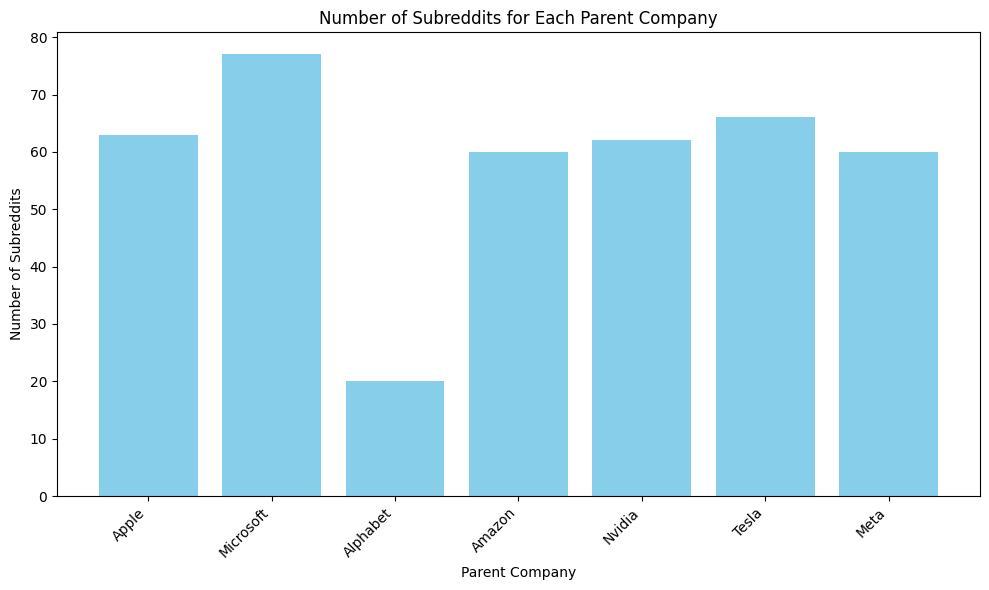

In [ ]:
# plot how many subreddits we ended up with for each parent company
parent_company_counts = {parent_company: len(subreddits) for parent_company, subreddits in subreddits_passed_topic_classifier.items()}
parent_companies = list(parent_company_counts.keys())
subreddit_counts = list(parent_company_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(parent_companies, subreddit_counts, color='skyblue')
plt.xlabel('Parent Company')
plt.ylabel('Number of Subreddits')
plt.title('Number of Subreddits for Each Parent Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Extracting relevant posts from subreddits

I need to extract posts from each subreddit (in proportional amounts). I can consider taking X amount of hot posts, X amount of controversial posts, etc. I can record the upvotes/downvote ratios. Pass it through a sentiment analysis model to give it a positive/negative score. I can also say get the top 3 comments and up to 3 of their subcomments and also run those through sentiment analysis so it adds on to the overall post's sentiment score to some capacity. It is likely that a lot of the posts might be neutral, so I should make sure I depict that properly in my results.

In [ ]:
await reddit.subreddit("playboicarti", fetch=True)

Subreddit(display_name='playboicarti')

In [ ]:
# get subreddit data that has passed the topic classifier
subreddits_passed_topic_classifier = await read_subreddit_classification_data_from_csv("subreddits_passed_topic_classifier.csv")

An error occurred while fetching subreddit AmazonWebServices: received 403 HTTP response


In [ ]:
subreddits_passed_topic_classifier

defaultdict(list,
            {'Apple': [(Subreddit(display_name='apple'),
               0.9459022283554077,
               0.054097793996334076),
              (Subreddit(display_name='AppleWatch'),
               0.9440438151359558,
               0.055956169962882996),
              (Subreddit(display_name='AppleMusic'),
               0.9431213736534119,
               0.05687863379716873),
              (Subreddit(display_name='iphone'),
               0.9252777695655823,
               0.07472218573093414),
              (Subreddit(display_name='appletv'),
               0.949877142906189,
               0.05012287199497223),
              (Subreddit(display_name='AppleCard'),
               0.9370117783546448,
               0.06298822164535522),
              (Subreddit(display_name='technology'),
               0.8963473439216614,
               0.10365273058414459),
              (Subreddit(display_name='applehelp'),
               0.9459660053253174,
               0.054034

In [ ]:
parent_company_posts = {}
parent_company_post_counts = {}
failed_subreddits = []
for parent_company, subreddits_and_scores in tqdm(subreddits_passed_topic_classifier.items()):
  # create a list of subreddits from the list of tuples that contain the subreddit objects
  subreddits = [item[0] for item in subreddits_and_scores]
  # get X amount of posts from each of the subreddits associated with the current parent company
  current_parent_company_posts, current_failed_subreddits = await probe_subs_for_posts(subreddits, num_posts=5)
  # store failed subreddits
  failed_subreddits.extend(current_failed_subreddits)
  # add key -> parent company, value -> dictionary where key is subreddit object and value is list of submission objects
  parent_company_posts[parent_company] = current_parent_company_posts
  # count how many posts are added per parent company
  parent_company_post_counts[parent_company] = sum(len(value) for key, value in current_parent_company_posts.items())
parent_company_post_counts, parent_company_posts, failed_subreddits

  0%|          | 0/7 [00:00<?, ?it/s]

Error processing posts from subreddit apple_news
Error processing posts from subreddit AppleWatchApps
Error processing posts from subreddit AppleIPTV


 14%|█▍        | 1/7 [00:09<00:58,  9.70s/it]

Error processing posts from subreddit AppleWatches
Error processing posts from subreddit Microsoft_Build
Error processing posts from subreddit MicrosoftInsiders


 29%|██▊       | 2/7 [01:29<04:14, 50.83s/it]

Error processing posts from subreddit TechNewsToday


 43%|████▎     | 3/7 [01:49<02:27, 36.96s/it]

Error processing posts from subreddit AmazonTopRated
Error processing posts from subreddit AmazonWebServices


 57%|█████▋    | 4/7 [02:49<02:17, 45.96s/it]

Error processing posts from subreddit GauGAN


 86%|████████▌ | 6/7 [04:57<00:56, 56.49s/it]

Error processing posts from subreddit OculusMods
Error processing posts from subreddit OculusNames
Error processing posts from subreddit OculusQuestGerman
Error processing posts from subreddit OculusQuest_Sverige


100%|██████████| 7/7 [05:58<00:00, 51.16s/it]


({'Apple': 152,
  'Microsoft': 197,
  'Alphabet': 82,
  'Amazon': 152,
  'Nvidia': 205,
  'Tesla': 152,
  'Meta': 112},
 {'Apple': defaultdict(list,
              {Subreddit(display_name='apple'): [Submission(id='1c2g9lx'),
                Submission(id='1c2lhr4'),
                Submission(id='1c2ojbt'),
                Submission(id='1c2l0rh'),
                Submission(id='1c2moii')],
               Subreddit(display_name='AppleWatch'): [Submission(id='1c279ms'),
                Submission(id='1c2ildr'),
                Submission(id='1c20qop'),
                Submission(id='1c2blfc'),
                Submission(id='1c2akzp')],
               Subreddit(display_name='AppleMusic'): [Submission(id='1c23zym'),
                Submission(id='1c2jekt'),
                Submission(id='1c20btg'),
                Submission(id='1c28y95'),
                Submission(id='1c2kjdy')],
               Subreddit(display_name='iphone'): [Submission(id='1c1ytvi'),
                Submission(id='1c

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Failed subreddits = " + str(failed_subreddits))
add_to_experiment_file("default_sentiment_analysis_experiment",  "Number of failed subreddits: " + str(len(failed_subreddits)))

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Number of posts extracted for each parent company = " + str(parent_company_post_counts))
add_to_experiment_file("default_sentiment_analysis_experiment", "Total number of posts = " + str(sum(parent_company_post_counts.values())))

### Visualize number of posts extracted for each parent company

In [ ]:
def visualize_company_posts(data):
    companies = list(data.keys())
    post_counts = list(data.values())

    plt.figure(figsize=(10, 6))
    plt.barh(companies, post_counts, color='skyblue')
    plt.xlabel('Number of Posts')
    plt.ylabel('Parent Companies')
    plt.title('Number of Posts Extracted from Each Parent Company Related Subreddits')
    plt.show()

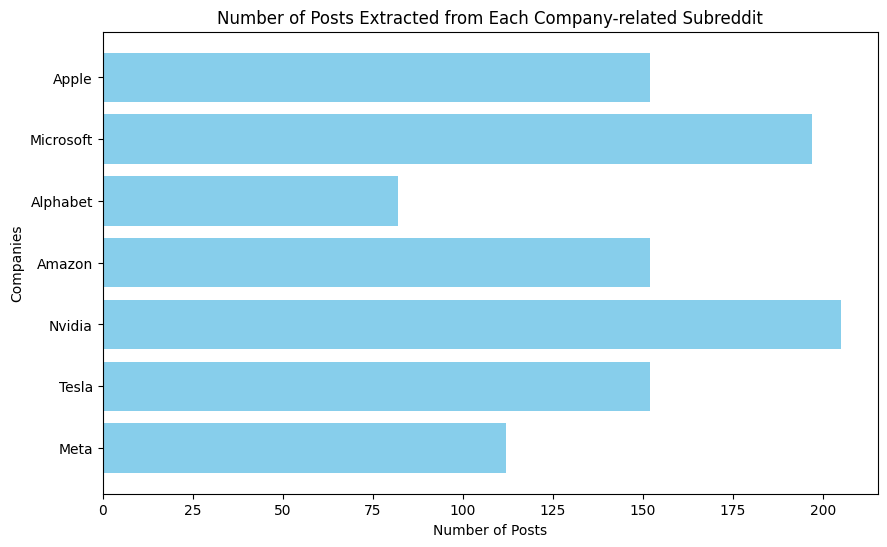

In [ ]:
visualize_company_posts(parent_company_post_counts)

### Write/read csv functions for subreddit ids and post ids

In [ ]:
def write_subreddit_data_to_csv(data: defaultdict, csv_filename: str):
    """
    Write subreddit data stored in a defaultdict to a CSV file.

    Args:
        data (defaultdict): A defaultdict containing subreddit objects and their submissions.
        csv_filename (str): The filename for the CSV file to be created.
        reddit: An instance of the Reddit API client.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Subreddit Display Name', 'Submission IDs']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, subreddit_data in data.items():
            for subreddit, submissions in subreddit_data.items():
                submission_ids = [submission.id for submission in submissions]
                writer.writerow({
                    'Parent Company': parent_company,
                    'Subreddit Display Name': subreddit.display_name,
                    'Submission IDs': ','.join(submission_ids)
                })

async def read_subreddit_data_from_csv(csv_filename: str) -> defaultdict:
  """
  Read subreddit data from a CSV file and reconstruct the defaultdict.

  Args:
      csv_filename (str): The filename of the CSV file to read.
      reddit: An instance of the Reddit API client.

  Returns:
      defaultdict: A defaultdict containing subreddit objects and their submission objects.
  """
  data = defaultdict(dict)

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
          parent_company = row['Parent Company']
          display_name = row['Subreddit Display Name']
          submission_ids = row['Submission IDs'].split(',')

          try:
            subreddit_object = await reddit.subreddit(display_name, fetch=True)
            submissions = [await reddit.submission(submission_id) for submission_id in submission_ids]
          except Exception as e:
            print(f"Error processing a post from subreddit {display_name}")
          data[parent_company][subreddit_object] = submissions

  return data


In [ ]:
write_subreddit_data_to_csv(parent_company_posts, "parent_company_post_ids.csv")

## Get post comments

In [ ]:
subreddits_and_post_ids = await read_subreddit_data_from_csv("parent_company_post_ids.csv")

Error processing a post from subreddit cordcutters


or

In [ ]:
subreddits_and_post_ids = parent_company_posts

In [ ]:
subreddits_and_post_ids

{'Apple': defaultdict(list,
             {Subreddit(display_name='apple'): [Submission(id='1c2g9lx'),
               Submission(id='1c2lhr4'),
               Submission(id='1c2ojbt'),
               Submission(id='1c2l0rh'),
               Submission(id='1c2moii')],
              Subreddit(display_name='AppleWatch'): [Submission(id='1c279ms'),
               Submission(id='1c2ildr'),
               Submission(id='1c20qop'),
               Submission(id='1c2blfc'),
               Submission(id='1c2akzp')],
              Subreddit(display_name='AppleMusic'): [Submission(id='1c23zym'),
               Submission(id='1c2jekt'),
               Submission(id='1c20btg'),
               Submission(id='1c28y95'),
               Submission(id='1c2kjdy')],
              Subreddit(display_name='iphone'): [Submission(id='1c1ytvi'),
               Submission(id='1c27011'),
               Submission(id='1c237xo'),
               Submission(id='1c27uhs'),
               Submission(id='1c2jsll')],
     

In [ ]:
post_comments = default_dict_dict_dict_list()
post_comment_counts = defaultdict(int)
for parent_company, subreddit_dict in tqdm(subreddits_and_post_ids.items()):
  for subreddit, posts in subreddit_dict.items():
    for post in posts:
      # get X relevant comments
      comments = await probe_submissions_for_comments(submission = post,
                                                      num_comments = 2,
                                                      sort_type = "best")
      post_comments[parent_company][subreddit][post] = comments
      post_comment_counts[parent_company] += len(comments)
post_comment_counts, post_comments

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-151-45803badbee9>:7: DeprecationWarning: `Submission.comments` is now a property and no longer needs to be awaited. This will raise an error in a future version of Async PRAW.
  comments = await probe_submissions_for_comments(submission = post,
<ipython-input-16-5a2553066f9f>:26: RuntimeWarning: coroutine 'CommentForest.replace_more' was never awaited
  comments.replace_more(limit=None)
100%|██████████| 7/7 [13:38<00:00, 116.95s/it]


(defaultdict(int,
             {'Apple': 246,
              'Microsoft': 274,
              'Alphabet': 137,
              'Amazon': 237,
              'Nvidia': 342,
              'Tesla': 238,
              'Meta': 165}),
 defaultdict(<function __main__.default_dict_dict_list()>,
             {'Apple': defaultdict(<function __main__.default_dict_list()>,
                          {Subreddit(display_name='apple'): defaultdict(list,
                                       {Submission(id='1c2g9lx'): [Comment(id='kz9tc14'),
                                         Comment(id='kz9uosc')],
                                        Submission(id='1c2lhr4'): [Comment(id='kzavoe7'),
                                         Comment(id='kzb2fof')],
                                        Submission(id='1c2ojbt'): [Comment(id='kzbdlx0'),
                                         Comment(id='kzbev1k')],
                                        Submission(id='1c2l0rh'): [Comment(id='kzau5ri'),
        

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Number of comments extracted for each parent company = " + str(post_comment_counts))
add_to_experiment_file("default_sentiment_analysis_experiment", "Total number of comments = " + str(sum(post_comment_counts.values())))

### Visualize the number of comments extracted from posts under each parent company

In [ ]:
def visualize_company_comments(data):
  companies = list(data.keys())
  comment_counts = list(data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, comment_counts, color='skyblue')
  plt.xlabel('Number of Comments')
  plt.ylabel('Companies')
  plt.title('Number of Comments Under Posts for Each Parent Company')
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest comment count on top
  plt.show()

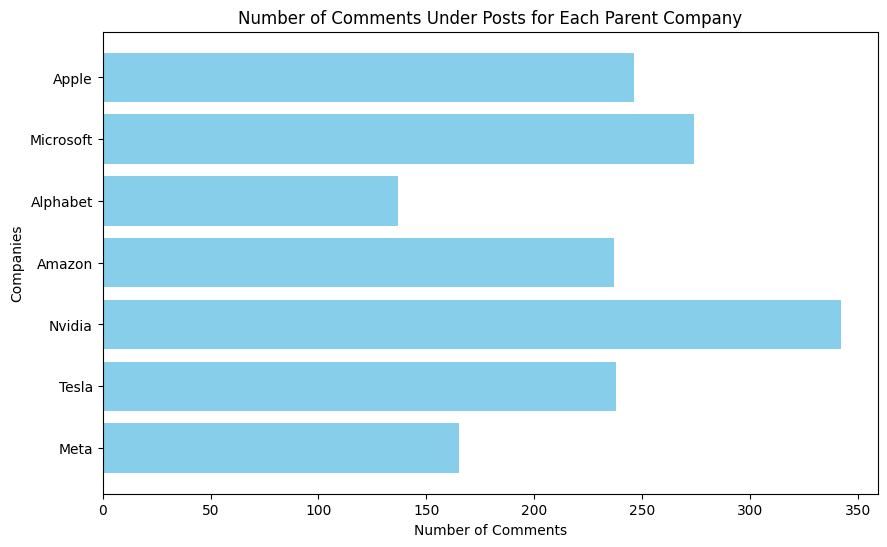

In [ ]:
visualize_company_comments(post_comment_counts)

### Write/read csv functions to storing comment ids for each post

In [ ]:
def write_post_comments_to_csv(data: dict, csv_filename: str) -> None:
  """
  Write post comments data to a CSV file.

  Args:
      data (dict): A dictionary where keys are Submission objects and values are lists of Comment objects.
      csv_filename (str): The filename for the CSV file to be created.

  Returns:
      None
  """
  with open(csv_filename, 'w', newline='') as csvfile:
      fieldnames = ['Parent Company', 'Subreddit Display Name', 'Submission ID', 'Comment IDs']
      writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
      writer.writeheader()

      for parent_company, subreddit_dict in data.items():
        for subreddit, posts in subreddit_dict.items():
          for post, comments in posts.items():
            writer.writerow({
                'Parent Company': parent_company,
                'Subreddit Display Name': subreddit.display_name,
                'Submission ID': post.id,
                'Comment IDs': ','.join(comment.id for comment in comments)
            })

async def read_post_comments_from_csv(csv_filename: str) -> dict:
  """
  Read post comments data from a CSV file and reconstruct the dictionary.

  Args:
      csv_filename (str): The filename of the CSV file to read.

  Returns:
      dict: A dictionary where keys are asyncpraw.models.Submission objects and values are lists of
          asyncpraw.models.Comment objects.
  """
  data = default_dict_dict_dict_list()
  failed_posts = []
  failed_comments = []

  with open(csv_filename, newline='') as csvfile:
      reader = csv.DictReader(csvfile)
      for row in tqdm(reader):
        parent_company = row['Parent Company']
        subreddit_display_name = row['Subreddit Display Name']
        submission_id = row['Submission ID']
        comment_ids = row['Comment IDs'].split(',')

        try:
            submission = await reddit.submission(submission_id)
        except Exception as e:
            print(f"Error processing submission {submission_id}: {e}")
            failed_posts.append(submission_id)

        comments = []
        for comment_id in comment_ids:
          try:
            if comment_id != "" and comment_id != None:
              comment = await reddit.comment(comment_id)
              comments.append(comment)
          except Exception as e:
              print(f"Error processing comment {comment_id}: {e}")
              failed_comments.append(comment_id)

        data[parent_company][subreddit_display_name][submission] = comments

  print(f"Failed to process {len(failed_posts)} posts and {len(failed_comments)} comments.")
  return data, failed_posts, failed_comments

In [ ]:
write_post_comments_to_csv(data=post_comments, csv_filename="post_comments.csv")

## Run post and comments through sentiment analysis model

In [ ]:
post_comments, failed_posts, failed_comments = await read_post_comments_from_csv(csv_filename="post_comments.csv")

682it [21:24,  2.72s/it]

Error processing comment kz9mzy7: received 429 HTTP response


911it [31:22,  2.89s/it]

Error processing comment j75qsdr: received 429 HTTP response


1052it [37:01,  2.11s/it]

Failed to process 0 posts and 2 comments.


### Failed posts and comments during import from csv

In [ ]:
failed_posts

[]

In [ ]:
failed_comments

['kz9mzy7', 'j75qsdr']

### Sentiment analysis calculation explanation

Run post title + text and associated comments through sentiment analysis.

Multiply the ratio of upvote/downvote for each of the post and comments by its sentiment score.

    Ex:
    "Economy sucks" 70k upvotes, sentiment score: 0.3

    "No it doesn't" 30k upvotes, sentiment score: 0.5

    (70,000 x 0.3 + 30,000 x 0.5)/(70,000 + 30,000) = 0.36

The weighted sentiment score would be 0.36, so negative sentiment about the state of the economy.

The default sentiment model gives you the numerical score for the sentiment for the stronger label, so if "Economy sucks" is more negative than positive, it'll give you the "Negative" Label with the score.

What would be a good way to tabulate the results?

    Ex:
    "Economy sucks" 70k upvotes, sentiment score: Negative->0.8

    "No the economy is actually great" 30k upvotes, sentiment score: Positive->0.9

    (70,000 x -0.8 + 30,000 x 0.9)/(70,000 + 30,000) = -0.29

    This is the sentiment score you get with the post and its comment considered together.

    Let's consider the case where the post and all the comments were 100% positive:

    (70,000 x 1 + 30,000 x 1)/(70,000 + 30,000) = 1

    Let's consider the case where the post and all the comments were 100% negative:

    (70,000 x -1 + 30,000 x -1)/(70,000 + 30,000) = -1

This means that the we are looking at a scale between -1 and 1 for the sentiment scores.

It might be interesting to compare Finbert and regular Bert sentiment analysis.

Or actually might need to scrap the whole financial aspect of it and just focus on regular sentiment analysis for now. It seems like financial sentiment analysis comes up neutral a lot when the text doesn't explicitly mention finance topics.

Potential sentiment analysis models:

* distilbert/distilbert-base-uncased-finetuned-sst-2-english

* ProsusAI/finbert

* ahmedrachid/FinancialBERT-Sentiment-Analysis

## Default sentiment analysis

In [ ]:
default_sentiment_analysis_client = InferenceClient(model="distilbert/distilbert-base-uncased-finetuned-sst-2-english", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = default_sentiment_analysis_client.text_classification("Economy is great")
output

[{'label': 'POSITIVE', 'score': 0.999854326248169},
 {'label': 'NEGATIVE', 'score': 0.00014564006414730102}]

In [ ]:
for post, comments in post_comments.items():
  print("Post username:", post.name)
  print("Post title:", post.title)
  print("Post selftext:", post.selftext)
  print("post upvote_ratio:", post.upvote_ratio)
  for comment in comments:
    print("Comment body:",  comment.body)
    print("Comment score:", comment.score)
    print("Comment parent_id:", comment.parent_id)

Streaming output truncated to the last 5000 lines.
>  
>It's a like-for-like replacement to Clippy - but made and maintained inside of reddit servers! The bot is called [/r/reputatorbot](https://www.reddit.com/r/reputatorbot)

In other words, nothing changes (except for the message you'll receive when you award a point).

So I'll tip my hat to the new botstitutionTake a bow for the new botolutionSmile and grin at the change all aroundPick up my keyboard and playJust like yesterdayThen I'll get on my knees and prayThat people start replying with "solution verified" one day.

(OK, I'll stop now.)

*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/MSAccess) if you have any questions or concerns.*
Comment score: 1
Comment parent_id: t3_1bfpczn
Comment body: Hold on, what the?

Clippy was a she?
Comment score: 3
Comment parent_id: t3_1bfpczn
Post name: t3_1bfnpnt
Post title: Help with MS Access Query (or Data 

Note: model only accepts 512 characters for inference.

In [ ]:
sentiments = defaultdict(list)
interactions = defaultdict(int)
for parent_company, subreddit_dict in tqdm(post_comments.items()):
  for subreddit, posts in subreddit_dict.items():
    for post, comments in posts.items():
      post_text = post.title + post.selftext
      post_sentiment = default_sentiment_analysis_client.text_classification(post_text[:512])

      if post_sentiment[0]['label'] == 'POSITIVE':
        post_sentiment = post_sentiment[0]['score']
      else:
        post_sentiment = -post_sentiment[0]['score']
      post_upvote_ratio = post.upvote_ratio

      total_interaction = 0
      total_interaction += post_upvote_ratio

      sentiment_weights = 0
      sentiment_weights += post_upvote_ratio * post_sentiment

      for comment in comments:
        comment_sentiment = default_sentiment_analysis_client.text_classification(comment.body[:512])
        if comment_sentiment[0]['label'] == 'POSITIVE':
          comment_sentiment = comment_sentiment[0]['score']
        else:
          comment_sentiment = -comment_sentiment[0]['score']
        comment_score = comment.score

        total_interaction += comment_score
        sentiment_weights += comment_score * comment_sentiment

      total_sentiment = sentiment_weights/total_interaction
      sentiments[parent_company].append(total_sentiment)
      interactions[parent_company] += total_interaction

100%|██████████| 7/7 [03:00<00:00, 25.85s/it]


In [ ]:
sentiments

defaultdict(list,
            {'Apple': [-0.9878905350777185,
              -0.9977302506557643,
              -0.9975079344808038,
              0.02842539088717418,
              -0.9955135370200535,
              -0.9949458887531106,
              0.8930381189264346,
              -0.9943194031080755,
              -0.9907055818871947,
              -0.9985402046396268,
              -0.42835567071776076,
              0.14349393504006522,
              -0.9755186141237798,
              -0.5580901718631233,
              -0.9900125981839888,
              0.9992427391337277,
              -0.544902865379868,
              -0.9978462641238716,
              0.1565713167108282,
              -0.9962824032043279,
              -0.9498481141917458,
              0.9991053938865662,
              -0.9691049988102761,
              -0.6880987653365502,
              -0.9801445766700121,
              -0.9741711358593996,
              -0.9967401150154741,
              -0.957000105670004

In [ ]:
# number of upvote/downvote ratio for all the posts and comments from all the subs
# combined for a specific company
interactions

defaultdict(int,
            {'Apple': 22657.05,
             'Microsoft': 53788.900000000016,
             'Alphabet': 22129.979999999985,
             'Amazon': 23168.010000000002,
             'Nvidia': 55761.15999999999,
             'Tesla': 30244.250000000004,
             'Meta': 39192.3})

In [ ]:
average_sentiments = {}
for parent_company, sentiment_values in sentiments.items():
  average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

average_sentiments

{'Apple': -0.4958714928295979,
 'Microsoft': -0.5239334755489509,
 'Alphabet': -0.5642052391340967,
 'Amazon': -0.5701419831614389,
 'Nvidia': -0.5390753126401039,
 'Tesla': -0.4805199832873646,
 'Meta': -0.4862868924245535}

In [ ]:
add_to_experiment_file("default_sentiment_analysis_experiment", "")
add_to_experiment_file("default_sentiment_analysis_experiment", "Model: distilbert/distilbert-base-uncased-finetuned-sst-2-english")
add_to_experiment_file("default_sentiment_analysis_experiment", "Average sentiments per parent company = " + str(average_sentiments))
add_to_experiment_file("default_sentiment_analysis_experiment", "Interactions per parent company = " + str(interactions))

### Visualize average sentiment scores and interactions for each company

In [ ]:
def visualize_average_sentiment(sentiment_data):
  companies = list(sentiment_data.keys())
  avg_sentiments = list(sentiment_data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, avg_sentiments, color='skyblue')
  plt.xlabel('Average Sentiment')
  plt.ylabel('Companies')
  plt.title('Average Sentiment per Parent Company')
  plt.xlim(-1, 1)  # Set the x-axis limits to range from -1 to 1
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest sentiment on top
  plt.show()

In [ ]:
def visualize_overall_interaction(interaction_data):
  companies = list(interaction_data.keys())
  interactions = list(interaction_data.values())

  plt.figure(figsize=(10, 6))
  plt.barh(companies, interactions, color='skyblue')
  plt.xlabel('Overall Interaction (Posts + Comments)')
  plt.ylabel('Companies')
  plt.title('Overall Interaction for Each Parent Company')
  plt.gca().invert_yaxis()  # Invert y-axis to display the company with the highest interaction on top
  plt.show()

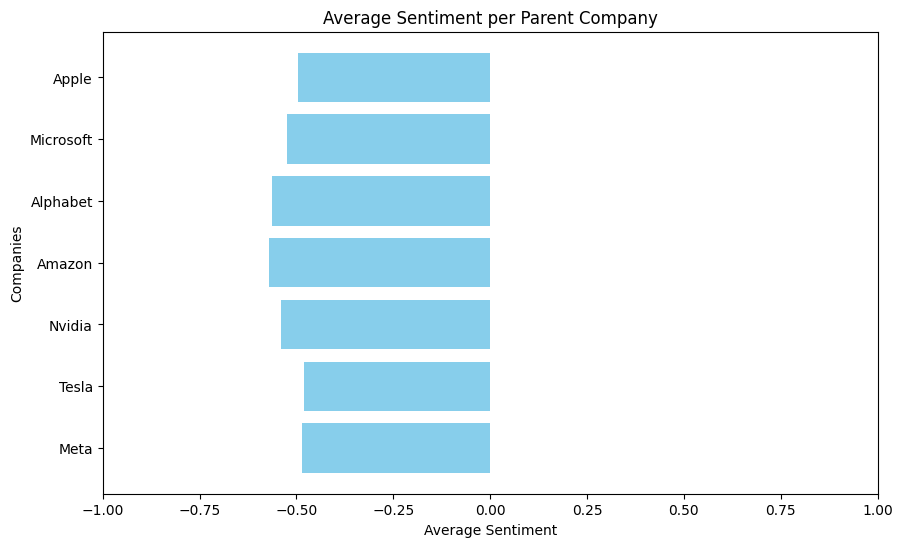

In [ ]:
visualize_average_sentiment(average_sentiments)

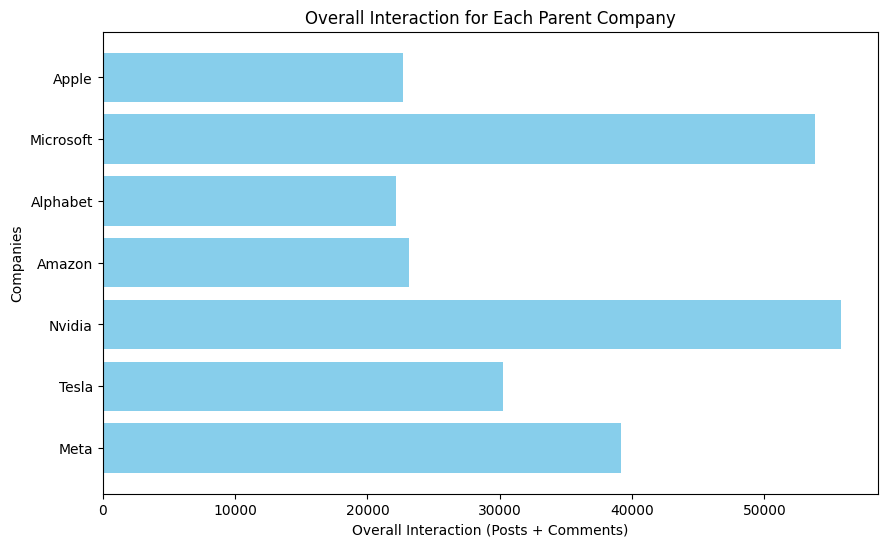

In [ ]:
visualize_overall_interaction(interactions)

### Write/read csv functions to parent company and average sentiment score

In [ ]:
def write_company_sentiments_to_csv(data: dict, csv_filename: str) -> None:
    """
    Write company average sentiment data to a CSV file.

    Args:
        data (dict): A dictionary where keys are str objects and values are int objects.
        csv_filename (str): The filename for the CSV file to be created.

    Returns:
        None
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = ['Parent Company', 'Average Sentiment']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for parent_company, average_sentiment in data.items():
          writer.writerow({
              'Parent Company': parent_company,
              'Average Sentiment': average_sentiment
          })

def read_company_sentiments_from_csv(csv_filename: str) -> dict[str, int]:
    """
    Read company average sentiment data from a CSV file and reconstruct the dictionary.

    Args:
        csv_filename (str): The filename of the CSV file to read.

    Returns:
        dict: A dictionary where keys are str objects and values are int objects.
    """
    data = default_dict_dict_dict_list()

    with open(csv_filename, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in tqdm(reader):
            parent_company = row['Parent Company']
            average_sentiment = row['Average Sentiment']
            data[parent_company] = average_sentiment

    return data

In [ ]:
write_company_sentiments_to_csv(data=average_sentiments, csv_filename="default_average_sentiment.csv")

## Financial sentiment analysis w/ ProsusAI/finbert

In [ ]:
finbert_client = InferenceClient(model="ProsusAI/finbert", token=userdata.get('HF_TOKEN_READ'))

In [ ]:
output = finbert_client.text_classification("Apple products are great")
output

[{'label': 'neutral', 'score': 0.9307236075401306},
 {'label': 'positive', 'score': 0.05205203592777252},
 {'label': 'negative', 'score': 0.017224431037902832}]

How to account for neutral in sentiment calculation?

Okay so my theory is, Finbert is super specific to financial data so it is going to return neutral for almost all the posts. What I'm going to do is ignore neutral posts and include only data where Finbert is positive or negative. This is probably not going to be used in the final model but might be insightful.

In [ ]:
finbert_sentiments = defaultdict(list)
finbert_positive_sentiments = defaultdict(int)
finbert_negative_sentiments = defaultdict(int)
for parent_company, subreddit_dict in tqdm(post_comments.items()):
  for subreddit, posts in subreddit_dict.items():
    for post, comments in posts.items():
      post_text = post.title + post.selftext
      post_sentiment = finbert_client.text_classification(post_text[:512])

      # if the highest score is neutral, ignore post
      if post_sentiment[0]['label'] == 'neutral':
        continue
      # if the highest score is positive or negative, process post
      else:
        # if the second highest score is positive
        if post_sentiment[1]['label'] == 'positive':
          post_sentiment = post_sentiment[1]['score']
          finbert_positive_sentiments[parent_company] += 1
        # if the second highest score is negative
        else:
          post_sentiment = -post_sentiment[1]['score']
          finbert_negative_sentiments[parent_company] += 1

        post_upvote_ratio = post.upvote_ratio

        total_interaction = 0
        total_interaction += post_upvote_ratio

        sentiment_weights = 0
        sentiment_weights += post_upvote_ratio * post_sentiment

        for comment in comments:
          comment_sentiment = finbert_client.text_classification(comment.body[:512])

          # if comment score is neutral, ignore comment
          if comment_sentiment[0]['label'] == 'neutral':
            continue
          # if comment score is positive or negative, process comment
          else:
            if comment_sentiment[1]['label'] == 'positive':
              comment_sentiment = comment_sentiment[1]['score']
              finbert_positive_sentiments[parent_company] += 1
            else:
              comment_sentiment = -comment_sentiment[1]['score']
              finbert_negative_sentiments[parent_company] += 1

            comment_score = comment.score

            total_interaction += comment_score
            sentiment_weights += comment_score * comment_sentiment

        total_sentiment = sentiment_weights/total_interaction
        finbert_sentiments[parent_company].append(total_sentiment)

100%|██████████| 7/7 [01:58<00:00, 16.90s/it]


In [ ]:
finbert_average_sentiments = {}
for parent_company, sentiment_values in finbert_sentiments.items():
  finbert_average_sentiments[parent_company] = sum(sentiment_values)/len(sentiment_values)

finbert_average_sentiments

{'Apple': -0.2793481230328574,
 'Microsoft': -0.26976720203982285,
 'Alphabet': -0.294599893211392,
 'Amazon': -0.25579221308790645,
 'Nvidia': -0.27865868585429665,
 'Tesla': -0.22161527096329664,
 'Meta': -0.29353727513441813}

In [ ]:
finbert_positive_sentiments

defaultdict(int, {'Apple': 1, 'Amazon': 1, 'Tesla': 1})

In [ ]:
finbert_negative_sentiments

defaultdict(int,
            {'Apple': 22,
             'Microsoft': 27,
             'Alphabet': 16,
             'Amazon': 27,
             'Nvidia': 35,
             'Tesla': 42,
             'Meta': 9})

In [ ]:
create_experiment_file("finbert_sentiment_analysis_experiment")

In [ ]:
add_to_experiment_file("finbert_sentiment_analysis_experiment", "Average sentiments per company = " + str(finbert_average_sentiments))
add_to_experiment_file("finbert_sentiment_analysis_experiment", "Total positive sentiments from posts and comments per company = " + str(finbert_positive_sentiments))
add_to_experiment_file("finbert_sentiment_analysis_experiment", "Total negative sentiments from posts and comments per company = " + str(finbert_negative_sentiments))

### Visualize average, positive, and negative sentiment scores

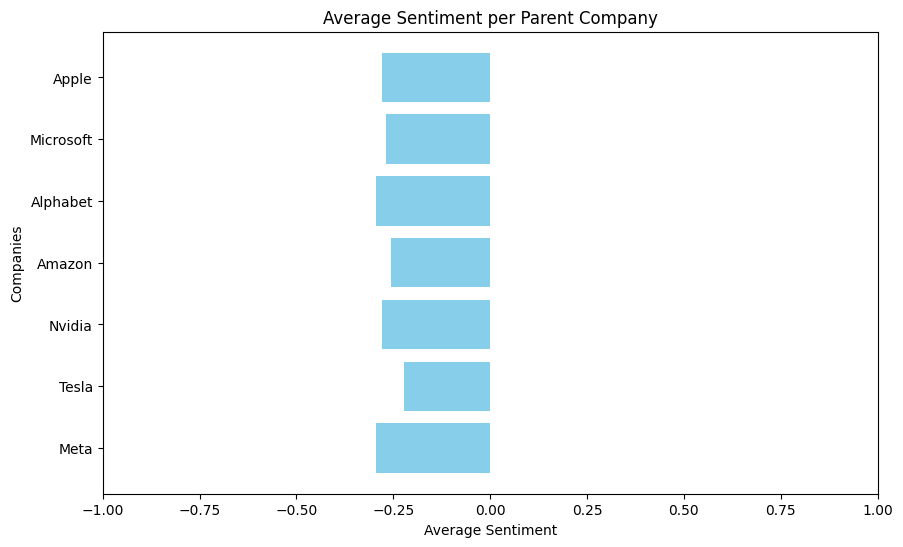

In [ ]:
visualize_average_sentiment(finbert_average_sentiments)

In [ ]:
def plot_total_positive_sentiments(positive_sentiments_data):
    companies = list(positive_sentiments_data.keys())
    total_positive_sentiments = list(positive_sentiments_data.values())

    plt.figure(figsize=(10, 6))
    plt.bar(companies, total_positive_sentiments, color='skyblue')
    plt.xlabel('Companies')
    plt.ylabel('Total Positive Sentiments')
    plt.title('Total Positive Sentiments from Posts and Comments per Company')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_total_negative_sentiments(negative_sentiments_data):
    companies = list(negative_sentiments_data.keys())
    total_negative_sentiments = list(negative_sentiments_data.values())

    plt.figure(figsize=(10, 6))
    plt.bar(companies, total_negative_sentiments, color='skyblue')
    plt.xlabel('Companies')
    plt.ylabel('Total Negative Sentiments')
    plt.title('Total Negative Sentiments from Posts and Comments per Company')
    plt.xticks(rotation=45, ha='right')
    plt.show()


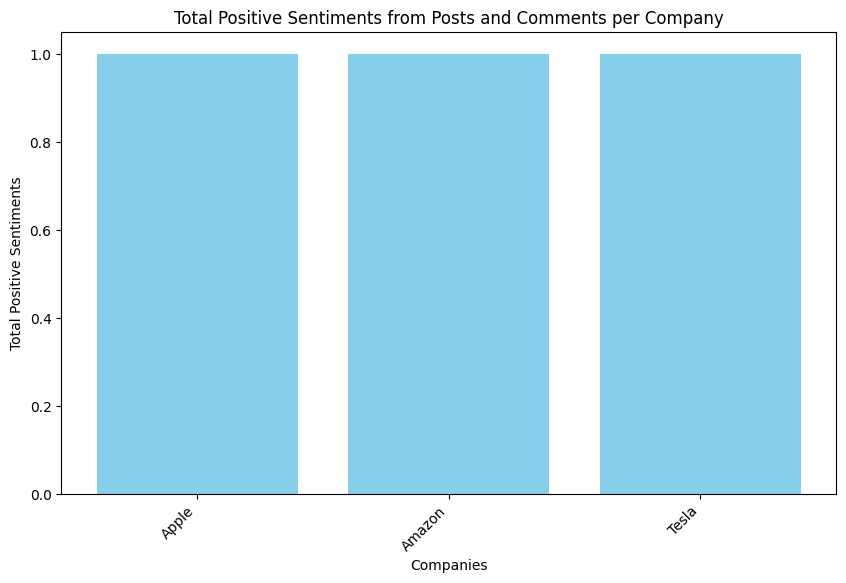

In [ ]:
plot_total_positive_sentiments(finbert_positive_sentiments)

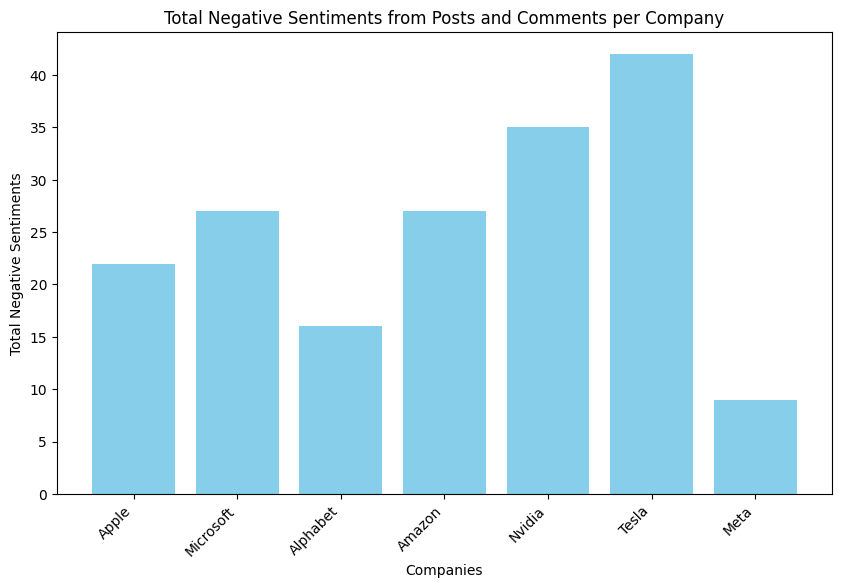

In [ ]:
plot_total_negative_sentiments(finbert_negative_sentiments)

In [ ]:
write_company_sentiments_to_csv(data=finbert_average_sentiments, csv_filename="finbert_average_sentiment.csv")

Wow, it looks like even with nearly 3,000 posts and comments considered, when a financial sentiment analysis model is run on it (ignoring neutrals), there are only three posts/comments that came out as being positive while there were several negative sentiments for each company.

# Next steps

Note for when I come back:

*   Get fresh data and csv files.
*   Write a few functions to actually analyze the contents of the data. Pick a few random posts and comments, read what the text actually says. A function that pre-processes the post and comment text before running it through sentiment analysis is necessary. I should also filter text on criteria of when it was posted to make sure it reflects data from today, and whether the text is empty or not.
*   Need to keep track of key metrics that might be relevant to the sentiment scores, like how many subreddits and posts were considered, what was the total interaction (AKA upvotes/downvotes the posts/comments received in totality)
*   Run default sentiment analysis model.
*   Run another sentiment analysis model that has a neutral option to see if that keeps the scores from skewing too far negative.
*   Run a financial sentiment analysis model to see how that affects the average sentiment.
*  Figure out how to automate this to run daily and save csv files to a location.
*  Figure out where to host so others can access.
*  I need to run this on more data. Maybe take more volume of posts and comments per subreddit.



Multiprocessing:

A cool opportunity for growth would be to figure out how to optimize this code. How can I use multiprocessing to get around rate limits? How to minimize requests?